In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import init
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial
import random
import os

In [2]:
seed = 999
random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) 
np.random.seed(seed) 
torch.cuda.manual_seed(seed) 
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False 

In [3]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / torch.Tensor([d_model]) * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            nn.GELU(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            nn.GELU(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


class UNet(nn.Module):
    def __init__(self, T, ch=128, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, dropout=0.1):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(1, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            nn.GELU(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

In [4]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''

        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = UNet(T)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None, None, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

        output = self.backbone(x_tilde, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output

# DDIM process

$$\large{x_{t-1}=\sqrt{\alpha_{t-1}} \underbrace{(\frac{x_t - \sqrt{1-\alpha_t}\epsilon_{\theta}^{(t)}(x_t)}{\sqrt{\alpha_t}})}_{\text{predicted }{x_0}} + \underbrace{\sqrt{1-\alpha_{t-1}-\sigma_t^2}\epsilon_{\theta}^{(t)}(x_t)}_{\text{direction pointing }{x_t}}+\underbrace{\sigma_t\epsilon_t}_{\text{random noise}}}$$

In [5]:
class DiffusionProcessDDIM():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape, eta, tau = 1, scheduling = 'uniform'):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        eta           : coefficient of sigma
        tau           : accelerating of diffusion process
        scheduling    : scheduling mode of diffusion process
        '''
        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])

        self.shape = shape
        self.sigmas = torch.sqrt((1 - self.alpha_prev_bars) / (1 - self.alpha_bars)) * torch.sqrt(1 - (self.alpha_bars / self.alpha_prev_bars))
        self.diffusion_fn = diffusion_fn
        self.device = device
        self.eta = eta
        self.tau = tau
        self.scheduling = scheduling
        
    def _get_process_scheduling(self, reverse = True):
        if self.scheduling == 'uniform':
            diffusion_process = list(range(0, len(self.alpha_bars), self.tau)) + [len(self.alpha_bars)-1]
        elif self.scheduling == 'exp':
            diffusion_process = (np.linspace(0, np.sqrt(len(self.alpha_bars)* 0.8), self.tau)** 2)
            diffusion_process = [int(s) for s in list(diffusion_process)] + [len(self.alpha_bars)-1]
        else:
            assert 'Not Implementation'
            
        
        diffusion_process = zip(reversed(diffusion_process[:-1]), reversed(diffusion_process[1:])) if reverse else zip(diffusion_process[1:], diffusion_process[:-1])
        return diffusion_process
            

    
    def _one_reverse_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        diffusion_process = self._get_process_scheduling(reverse = True)

        for prev_idx, idx in diffusion_process:
            self.diffusion_fn.eval()
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            predict_epsilon = self.diffusion_fn(x, idx)
            sigma = self.sigmas[idx] * self.eta
            
            predicted_x0 = torch.sqrt(self.alpha_bars[prev_idx]) * (x - torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon) / torch.sqrt(self.alpha_bars[idx])
            direction_pointing_to_xt = torch.sqrt(1 - self.alpha_bars[prev_idx] - sigma**2 ) * predict_epsilon
            x = predicted_x0 + direction_pointing_to_xt + sigma * noise

            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, sample=None, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if sample==None:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device)
            
        sampling_list = []
        
        final = None
        for sample in self._one_reverse_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

    
    @torch.no_grad()
    def probabilityflow(self, x, reverse):
        '''
        reverse : if True, backward(noise -> data) else forward(data -> noise)
        '''
        def reparameterize_sigma(idx):
            return torch.sqrt( (1-self.alpha_bars[idx]) / self.alpha_bars[idx] )
        def reparameterize_x(x, idx):
            return x / torch.sqrt(self.alpha_bars[idx])
        
        diffusion_process = self._get_process_scheduling(reverse = reverse)
        for idx_delta_t, idx in diffusion_process:
            self.diffusion_fn.eval()
            x_bar_delta_t = reparameterize_x(x, idx) + 0.5 * (reparameterize_sigma(idx_delta_t)**2 - reparameterize_sigma(idx)**2) / reparameterize_sigma(idx) * self.diffusion_fn(x, idx)
            x = x_bar_delta_t * torch.sqrt(self.alpha_bars[idx_delta_t])

        return x

In [6]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [7]:
def make_grid(sample, sampling_number = 64):
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    return show_sample

In [8]:
def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(10, 10))
    clear_output()
    show_sample = make_grid(sample, sampling_number)

    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [9]:
beta_1 = 1e-4
beta_T = 0.02
T = 1000
shape = (1, 16, 16)
device = torch.device('cuda:0')
eta = 1
tau = 1
model = Model(device, beta_1, beta_T, T)
process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
total_iteration = 5000
current_iteration = 0
display_iteration = 1000

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((shape[-2], shape[-1])),
    torchvision.transforms.ToTensor()
])

sampling_number = 16
only_final = True

dataset = torchvision.datasets.MNIST(root = './MNIST', train=True, download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, drop_last = True, num_workers = 10)
dataiterator = iter(dataloader)

losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


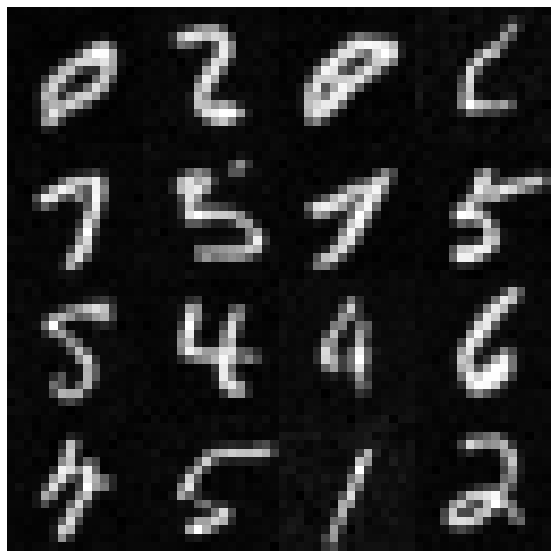

In [12]:
while current_iteration != total_iteration:
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data[0].to(device = device)
    loss = model.loss_fn(data)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    losses.update(loss.item())
    progress.display(current_iteration)
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
        sample = process.sampling(sampling_number, only_final = only_final)
        imshow(sample, sampling_number)
        losses.reset()

# DDPM generation

In [13]:
sampling_number = 64
z_first = torch.randn(sampling_number, 1, 16, 16).to(device = device)

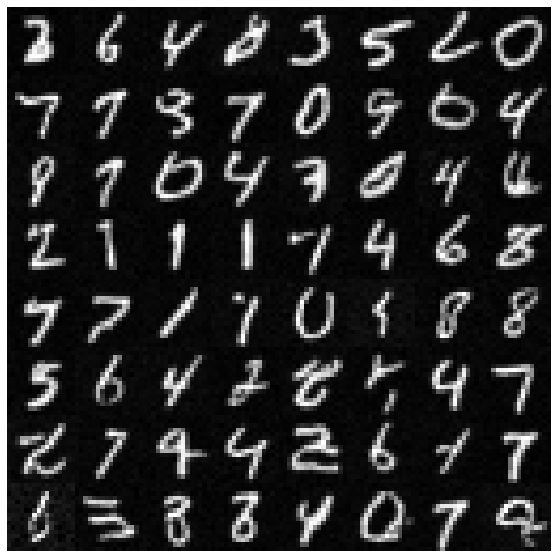

In [14]:
eta = 1
processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
x_DDPM = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDPM, sampling_number)

# DDIM generation

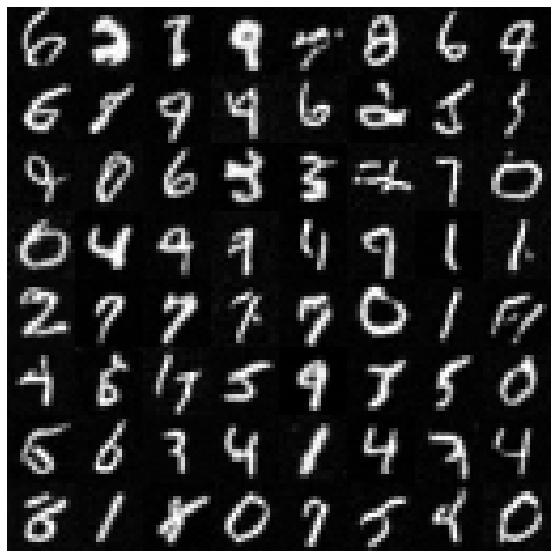

In [36]:
eta = 0
processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
x_DDIM = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM, sampling_number)

# reproducibility of DDIM

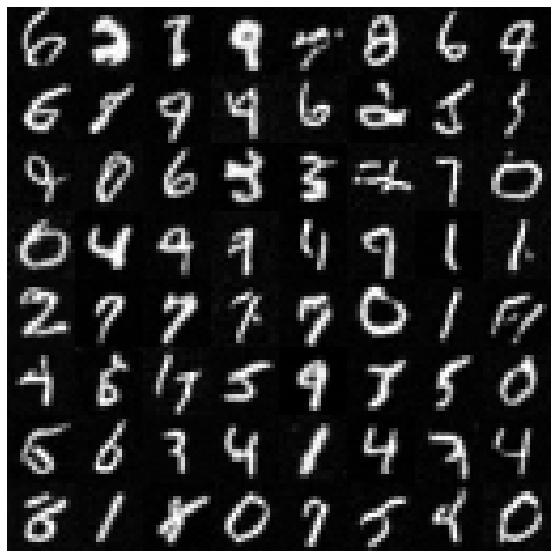

In [37]:
eta = 0

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
x_DDIM_re = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_re, sampling_number)

# Accelerated Generation Process

$$ \large{\sigma_{\tau_i}(\eta) = \eta\sqrt{ {(1-\alpha_{\tau_{i-1}})} / {(1-\alpha_{\tau_i})} }\sqrt{1-{\alpha_{\tau_i}}/{\alpha_{\tau_{i-1}}}} \text{           , sub-sequences } \tau \text{ of }[1, ... T]} \text{ and S = length of }\tau$$

$\normalsize{\text{Accelerated rates : }5\times}$

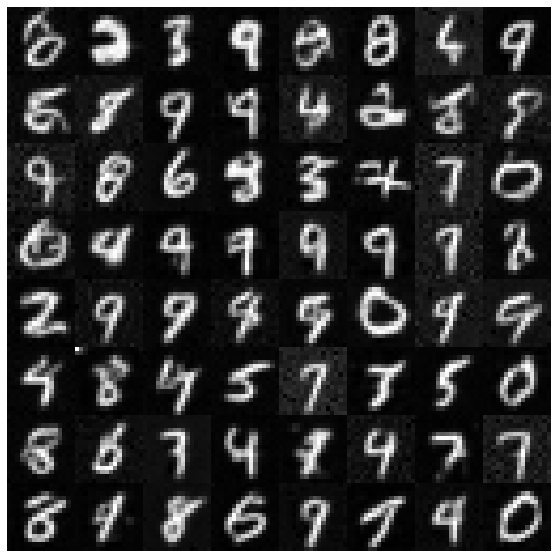

In [17]:
eta = 0
tau = 5

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta, tau = tau, scheduling = 'exp')
x_DDIM_5X = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_5X, sampling_number)

$\normalsize{\text{Accelerated rates : }10\times}$

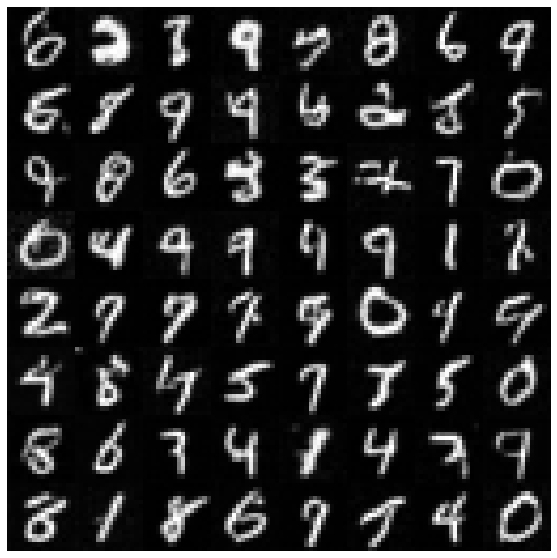

In [18]:
eta = 0
tau = 10

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta, tau = tau, scheduling = 'exp')
x_DDIM_10X = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_10X, sampling_number)

$\normalsize{\text{Accelerated rates : }100\times}$

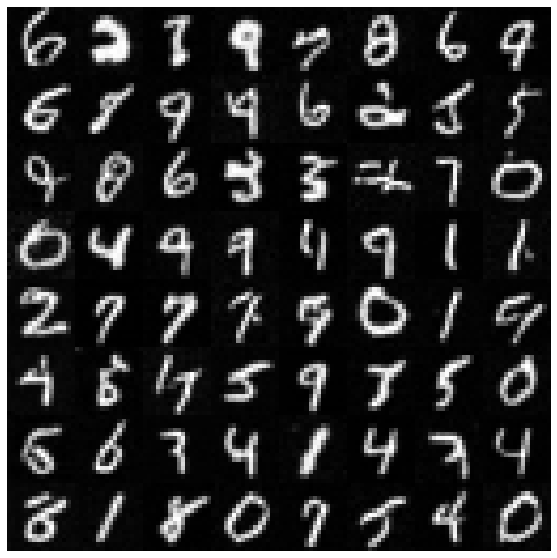

In [22]:
eta = 0
tau = 100

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta, tau = tau, scheduling = 'exp') # DDPM
x_DDIM_100X = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_100X, sampling_number)

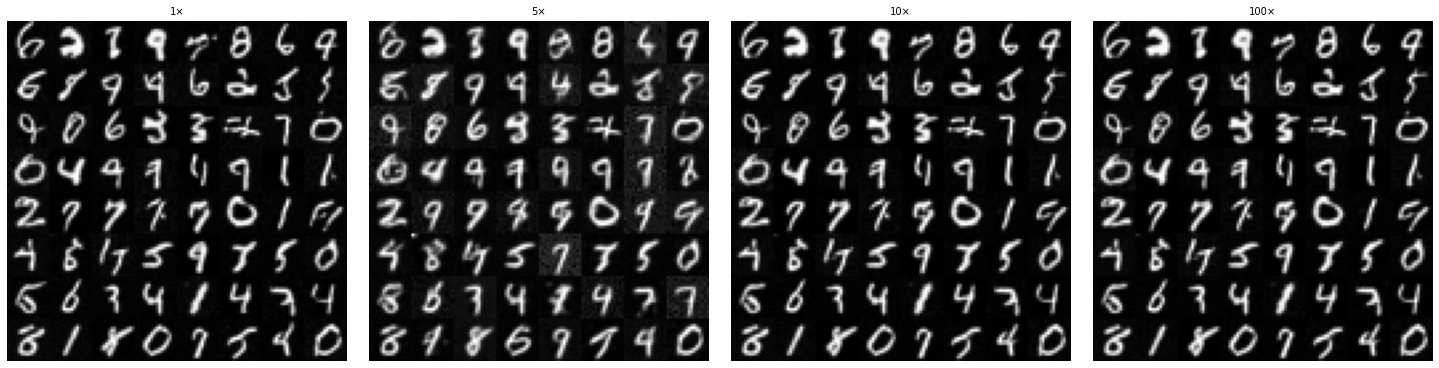

In [33]:
x_DDIM_1X_grid = make_grid(x_DDIM)
x_DDIM_5X_grid = make_grid(x_DDIM_5X)
x_DDIM_10X_grid = make_grid(x_DDIM_10X)
x_DDIM_100X_grid = make_grid(x_DDIM_100X)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout = True)

axs[0].imshow(x_DDIM_1X_grid, cmap = 'gray')
axs[1].imshow(x_DDIM_5X_grid, cmap = 'gray')
axs[2].imshow(x_DDIM_10X_grid, cmap = 'gray')
axs[3].imshow(x_DDIM_100X_grid, cmap = 'gray')

for i in range(4):
    axs[i].axis(False)

axs[0].set_title('1×', fontsize = 10)
axs[1].set_title('5×', fontsize = 10)
axs[2].set_title('10×', fontsize = 10)
axs[3].set_title('100×', fontsize = 10)

plt.savefig('Accelerating.png')
plt.show()

# Probability Flow ODE

$$ \large{\frac{x_{t-\Delta{t}}}{\sqrt{\alpha_{t-\Delta{t}}}} = \frac{x_{t}}{\sqrt{\alpha_{t}}}+\frac{1}{2}(\frac{1-\alpha_{t-\Delta{t}}}{\alpha_{t-\Delta{t}}}-\frac{1-\alpha_{t}}{\alpha_{t}})\sqrt{ \frac{\alpha_{t}}{1-\alpha_{t}} }\epsilon_{\theta}^{(t)}(x_t)}$$

### Original -> Encoding -> Reconstruction

In [29]:
tau = 1
processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta, tau = tau)
x_original = x_DDIM.clamp(0, 1)

x_original2fw    = processDDIM.probabilityflow(x_original,    reverse = False)   # Forward
x_ofiginal2fw2bw = processDDIM.probabilityflow(x_original2fw, reverse = True)    # Backward

x_original_grid       = make_grid(x_original)
x_original2fw_grid    = make_grid(x_original2fw)
x_ofiginal2fw2bw_grid = make_grid(x_ofiginal2fw2bw)

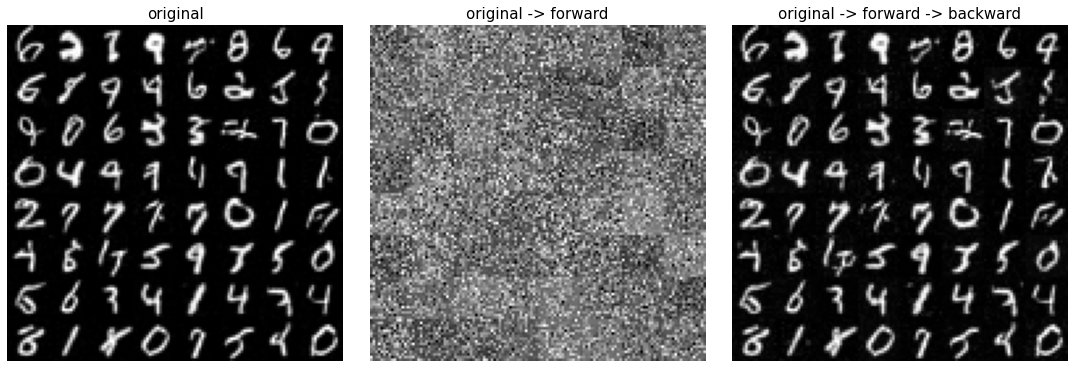

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout = True)

axs[0].imshow(x_original_grid, cmap = 'gray')
axs[1].imshow(x_original2fw_grid, cmap = 'gray')
axs[2].imshow(x_ofiginal2fw2bw_grid, cmap = 'gray')

for i in range(3):
    axs[i].axis(False)

axs[0].set_title('original', fontsize = 15)
axs[1].set_title('original -> forward', fontsize = 15)
axs[2].set_title('original -> forward -> backward', fontsize = 15)

plt.savefig('Probability Flow ODE-o2f2b.png')
plt.show()

### Noise -> Generation -> Encoding

In [31]:
z_original = torch.randn(sampling_number, 1, 16, 16).to(device = device)
z_original2bw = processDDIM.probabilityflow(z_original, reverse = True)
z_original2bw2fw = processDDIM.probabilityflow(z_original2bw, reverse = False)

z_original_grid = make_grid(z_original)
z_original2bw_grid = make_grid(z_original2bw)
z_original2bw2fw_grid = make_grid(z_original2bw2fw)

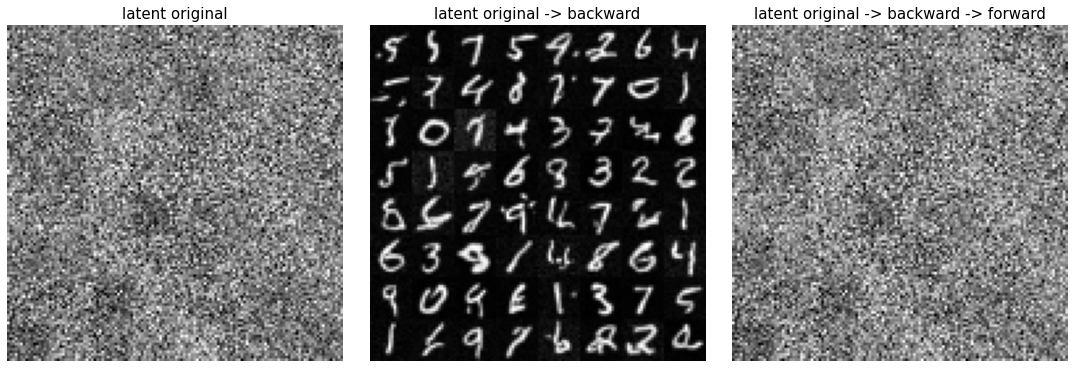

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout = True)

axs[0].imshow(z_original_grid, cmap = 'gray')
axs[1].imshow(z_original2bw_grid, cmap = 'gray')
axs[2].imshow(z_original2bw2fw_grid, cmap = 'gray')

for i in range(3):
    axs[i].axis(False)

axs[0].set_title('latent original', fontsize = 15)
axs[1].set_title('latent original -> backward', fontsize = 15)
axs[2].set_title('latent original -> backward -> forward', fontsize = 15)

plt.savefig('Probability Flow ODE-l2b2f.png')
plt.show()